# Jax, Optax, Haiku and Convolutional Neural Networks



<a href="https://colab.research.google.com/github/khipu-ai/practicals-2023/blob/main/notebooks/jax_optax_haiku_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copyright

* Deep Learning Indaba 2022. Apache License 2.0.
* Khipu 2023. Apache License 2.0.

## Authors

* Kale-ab Tessera (Indaba 2022)
* Ignacio Ramírez (Khipu 2023)

## Reviewers
* Javier Antoran
* James Allingham
* Ruan van der Merwe
* Sebastian Bodenstein
* Laurence Midgley
* Joao Guilherme
* Elan van Biljon


# Introduction

We begin by introducing JAX. JAX is a library that allows for very efficient speedups in the aforementioned operations by transparently choosing the best available hardware (CPU, GPU, TPU, etc.) and provinding with a number of acceleration and automation mechanisms such as automatic differentiation (`grad`), parallelization (`pmap`), vectorization (`vmap`) and just-in-time compilation (`jit`).

We will then show you how to use the [Optax](https://github.com/deepmind/optax) library, an efficient optimization library based on JAX.

We'll then show you how to use  [Haiku](https://github.com/deepmind/dm-haiku),  for building and training neural networks.


## Topics

* Accelerated computation with JAX
* Optimization with Optax
* Model training with Haiku
* Training a Convolutional Neural Network with Haiku

## Prerequisites

This practical assumes that you are familiar with:
* Python and NumPy
* Basic object oriented programming
* Basic optimization (gradient descent, etc.)
* Basic model learning (linear models)

## Hardware requirements (**important**)

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.



## Installation and Imports

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

import os

# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()
else:
    print("Only CPU accelerator is connected.")
    # x8 cpu devices - number of (emulated) host devices
    os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, pmap

import matplotlib.pyplot as plt
import numpy as np

a GPU is connected.


In [ ]:
# @title Helper Functions. (Run Cell)
import copy
from typing import Dict


def plot_performance(data: Dict, title: str):
    runs = list(data.keys())
    time = list(data.values())

    # creating the bar plot
    plt.bar(runs, time, width=0.35)

    plt.xlabel("Implementation")
    plt.ylabel("Average time taken (in s)")
    plt.title(title)
    plt.show()

    best_perf_key = min(data, key=data.get)
    all_runs_key = copy.copy(runs)

    # all_runs_key_except_best
    all_runs_key.remove(best_perf_key)

    for k in all_runs_key:
        print(
            f"{best_perf_key} was {round((data[k]/data[best_perf_key]),2)} times faster than {k} !!!"
        )

In [ ]:
# @title Check the device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 1
 Devices: [GpuDevice(id=0, process_index=0)]


$$
\newcommand{\because}[1]{&& \triangleright \textrm{#1}}
$$

<hr>

# PART 1 - JAX

<hr>

## Similarities between JAX and NumPy 

The main similarity between JAX and NumPy is that they share a similar interface and often, JAX and NumPy arrays can be used interchangeably.The code below shows this. 

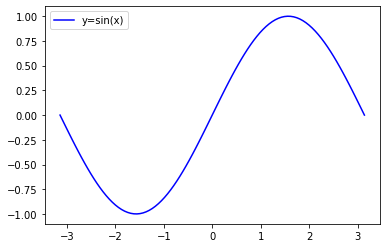

In [ ]:
#@title Using NumPy

# 100 linearly spaced numbers from -np.pi to np.pi
x = np.linspace(-np.pi, np.pi, 100)

# the function, which is y = sin(x) here
y = np.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

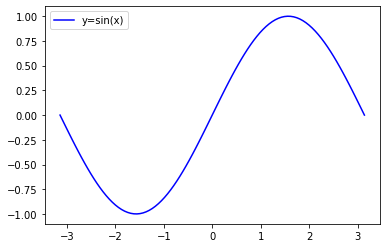

In [ ]:
#@title using JAX
# 100 linearly spaced numbers from -jnp.pi to jnp.pi
x = jnp.linspace(-jnp.pi, jnp.pi, 100)

# the function, which is y = sin(x) here
y = jnp.sin(x)

# plot the functions
plt.plot(x, y, "b", label="y=sin(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

**Exercise 1.1 - Code Task:** Can you plot the cosine function using `jnp`?

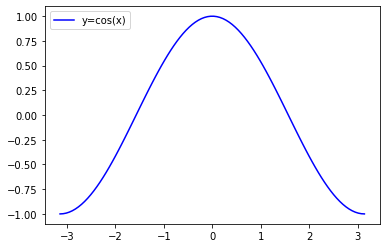

In [ ]:
#@title Excercise 1.1
#
# Plot Cosine using jnp

# 100 linearly spaced numbers

x = jnp.linspace(-jnp.pi, jnp.pi, 100)

# the function, which is y = sin(x) here
y = jnp.cos(x)

#
# plot the functions
#
plt.plot(x, y, "b", label="y=cos(x)")
plt.legend(loc="upper left")
plt.show()

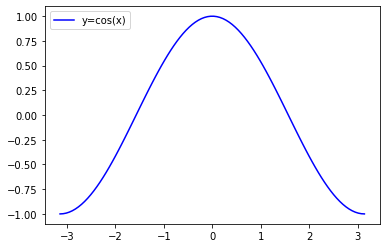

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
# 100 linearly spaced numbers
x = jnp.linspace(-jnp.pi, jnp.pi, 100)

y = jnp.cos(x)

# plot the functions
plt.plot(x, y, "b", label="y=cos(x)")

plt.legend(loc="upper left")

# show the plot
plt.show()

## Differences between JAX and NumPy


### JAX arrays are immutable, NumPy arrays are not

JAX and NumPy arrays are often interchangeable, **but** Jax arrays are **immutable** (they can't be modified after they are created). Allowing mutations makes transforms difficult and violates conditions for [pure functions](https://en.wikipedia.org/wiki/Pure_function).



### NumPy

Let's see this in practice by changing the number at the beginning of an array. 

In [ ]:
# NumPy: mutable arrays
x = np.arange(10)
x[0] = 10
print(x)

[10  1  2  3  4  5  6  7  8  9]


### JAX

In [ ]:
# JAX: immutable arrays
# Should raise an error.
try:
    x = jnp.arange(10)
    x[0] = 10
except Exception as e:
    print("Exception {}".format(e))

Exception '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


So it fails! We can't mutate a JAX array once it has been created. To update JAX arrays, we need to use [helper functions](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html) that return an updated copy of the JAX array. 

Instead of doing this `x[idx] = y`, we need to do this `x = x.at[idx].set(y)`. 

In [ ]:
x = jnp.arange(10)
new_x = x.at[0].set(10)
print(f" new_x: {new_x} original x: {x}")

 new_x: [10  1  2  3  4  5  6  7  8  9] original x: [0 1 2 3 4 5 6 7 8 9]


Note here that `new_x` is a copy and that the original `x` is unchanged. 

## Random number generation in NumPy and JAX 

JAX is more explicit in Pseudo Random Number Generation (PRNG) than `NumPy` and other libraries (such as `TensorFlow` or `PyTorch`). [PRNG](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) is the process of algorithmically generating a sequence of numbers, which *approximate* the properties of a sequence of random numbers.  

Let's see the differences in how JAX and NumPy generate random numbers.

**Extra reading**: "The Hitchhiker's Guide to the Galaxy" by Douglas Adams

##### In Numpy, PRNG is based on a global `state`.

Let's set the initial seed.

In [ ]:
# Set random seed
# If you don't know why this is 42, read the Hitchhiker's Guide to the Galaxy by Douglas Adams
np.random.seed(42)
prng_state = np.random.get_state()

In [ ]:
# @title Helper function to compare prng keys (Run Cell)
def is_prng_state_the_same(prng_1, prng_2):
    """Helper function to compare two prng keys."""
    # concat all elements in prng tuple
    list_prng_data_equal = [(a == b) for a, b in zip(prng_1, prng_2)]
    # stack all elements together
    list_prng_data_equal = np.hstack(list_prng_data_equal)
    # check if all elements are the same
    is_prng_equal = all(list_prng_data_equal)
    return is_prng_equal

Let's take a few samples from a Gaussian (normal) Distribution and check if PRNG keys/global state change.

In [ ]:
print(
    f"sample 1 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 2 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)
prng_state = np.random.get_state()
print(
    f"sample 3 = {np.random.normal()} Did prng state change: {not is_prng_state_the_same(prng_state,np.random.get_state())}"
)

sample 1 = 0.4967141530112327 Did prng state change: True
sample 2 = -0.13826430117118466 Did prng state change: True
sample 3 = 0.6476885381006925 Did prng state change: True


Numpy's global random state is updated every time a random number is generated, so *sample 1 != sample 2 != sample 3*. 

Having the state automatically updated, makes it difficult to handle randomness in a **reproducible** way across different threads, processes and devices. 

##### In JAX, PRNG is explicit.

In JAX, for each random number generation, you need to explicitly pass in a random key/state.

Passing the same state/key results in the same number being generated. This is generally undesirable.

In [ ]:
from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")
print(f"sample 2 = {random.normal(key)}")
print(f"sample 3 = {random.normal(key)}")

sample 1 = -0.1847117692232132
sample 2 = -0.1847117692232132
sample 3 = -0.1847117692232132


To generate different and independent samples, you need to manually **split** the keys. 

In [ ]:
from jax import random

key = random.PRNGKey(42)
print(f"sample 1 = {random.normal(key)}")

# We split the key -> new key and subkey
new_key, subkey = random.split(key)

# We use the subkey immediately and keep the new key for future splits.
# It doesn't really matter which key we keep and which one we use immediately.
print(f"sample 2 = {random.normal(subkey)}")

# We split the new key -> new key2 and subkey
new_key2, subkey = random.split(new_key)
print(f"sample 3 = {random.normal(subkey)}")

sample 1 = -0.1847117692232132
sample 2 = 1.369469404220581
sample 3 = -0.19947023689746857


By using JAX, we can more easily reproduce random number generation in parallel across threads, processes, or even devices by explicitly passing and keeping track of the prng key (without relying on a global state that automatically gets updated). For more details on PRNG in JAX, you can read more [here](https://jax.readthedocs.io/en/latest/jep/263-prng.html). 

### Acceleration in JAX 🚀

JAX leverages Autograd and XLA for accelerating numerical computation. The use of Autograd allows for automatic differentiation (`grad`), while XLA allows JAX to run on multiple accelerators/backends and run transforms like `jit` and `pmap`. JAX also allows you to use `vmap` for automatic vectorization.  

### JAX is backend Agnostic

Using JAX, you can run the same code on different backends/AI accelerators (e.g. CPU/GPU/TPU), **with no changes in code** (no more `.to(device)` - from frameworks like PyTorch). This means we can easily run linear algebra operations directly on GPU/TPU.

**Multiplying Matrices**

Dot products are a common operation in numerical computing and a central part of modern deep learning. They are defined over [vectors](https://en.wikipedia.org/wiki/Coordinate_vector), which can loosely be thought of as a list of multiple scalers (single values). 

Formally, given two vectors $\boldsymbol{x}$,$\boldsymbol{y}$ $\in R^n$, their dot product is defined as:

<center>$\boldsymbol{x}^{\top} \boldsymbol{y}=\sum_{i=1}^{n} x_{i} y_{i}$</center>

Dot Product in NumPy (will run on cpu)

In [ ]:
size = 1000
x = np.random.normal(size=(size, size))
y = np.random.normal(size=(size, size))
numpy_time = %timeit -o -n 10 a_np = np.dot(y,x.T)

38.9 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Dot Product using JAX (will run on current runtime - e.g. GPU).

In [ ]:
size = 1000
key1, key2 = jax.random.split(jax.random.PRNGKey(42), num=2)
x = jax.random.normal(key1, shape=(size, size))
y = jax.random.normal(key2, shape=(size, size))
jax_time = %timeit -o -n 10 jnp.dot(y, x.T).block_until_ready()

The slowest run took 100.17 times longer than the fastest. This could mean that an intermediate result is being cached.
20.5 ms ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)



> When timing JAX functions, we use `.block_until_ready()` because JAX uses [asynchronous dispatch](https://jax.readthedocs.io/en/latest/async_dispatch.html#async-dispatch). This means JAX doesn't wait for the operation to complete before returning control to your code. To fairly compute the time taken for JAX operations, we therefore block until the operation is done.



How much faster was the dot product in JAX (Using GPU)?

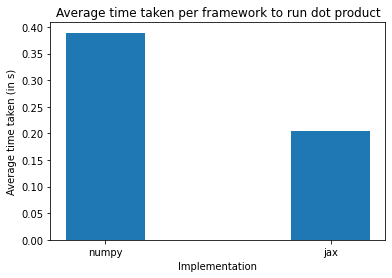

jax was 1.9 times faster than numpy !!!


In [ ]:
np_average_time = np.mean(numpy_time.all_runs)
jax_average_time = np.mean(jax_time.all_runs)
data = {"numpy": np_average_time, "jax": jax_average_time}

plot_performance(data, title="Average time taken per framework to run dot product")

JAX not running much faster? -> Re-run the JAX cell.                       
> "Keep in mind that the first time you run JAX code, it will be slower because it is being compiled. T*his is true even if you don’t use jit in your own code, because JAX’s builtin functions are also jit compiled*." - [JAX Docs](https://jax.readthedocs.io/en/latest/faq.html#benchmarking-jax-code).

If you are running on an accelerator, you should see a considerable performance benefit of using JAX, without making any changes to your code! 







# JAX Transformations

JAX transforms (`jit`, `grad`, `vmap`, `pmap`) first convert python functions into an intermediate language called *jaxpr*. Transforms are then applied to this jaxpr representation.

JAX generates jaxpr, in a process known as **tracing**. During tracing, function inputs are wrapped by a tracer object and then JAX records all operations (including regular python code) that occur during the function call. These recorded operations are used to reconstruct the function. 

Any python side-effects are not recorded during tracing. JAX transforms and compilations are designed to work only with **pure functions**. For more on tracing and jaxpr, you can read [here](https://jax.readthedocs.io/en/latest/jaxpr.html).



## JIT (Just in Time) compilation

Jax dispatches operations to accelerators one at a time. If we have repeated operations, we can use `jit` to compile the function the first time it is called, then subsequent calls will be [cached](https://en.wikipedia.org/wiki/Cache_(computing) (save the compiled version so that it doesn't need to be recompiled everytime we call it). 

Let's compile [ReLU (Rectified Linear Unit)](https://arxiv.org/abs/1803.08375), a popular activation function in deep learning. 

ReLU is defined as follows:
<center>$f(x)=max(0,x)$</center>

It can be visualized as follows:

<center>
<img src="https://machinelearningmastery.com/wp-content/uploads/2018/10/Line-Plot-of-Rectified-Linear-Activation-for-Negative-and-Positive-Inputs.png" width="35%" />
</center>,

where $x$ is the input to the function and $y$ is output of ReLU.


$$f(x)=\max (0, x)=\left\{\begin{array}{l}x_{i} \text { if } x_{i}>0 \\ 0 \text { if } x_{i}<=0\end{array}\right.$$

**Exercise 1.2 - Code Task:** Complete the ReLU implementation below using standard python.

In [ ]:
# Implement ReLU.
def relu(x):
    if x > 0:
        return x
        # TODO Implement me!
    else:
        return 0
        # TODO Implement me!

Your ReLU function is correct!


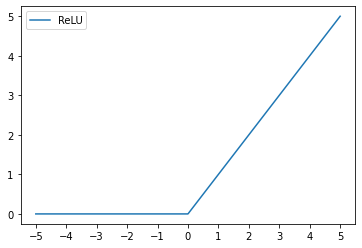

In [ ]:
# @title Run to test your function.


def plot_relu(relu_function):
    max_int = 5
    # Generete 100 evenly spaced points from -max_int to max_int
    x = np.linspace(-max_int, max_int, 1000)
    y = np.array([relu_function(xi) for xi in x])
    plt.plot(x, y, label="ReLU")
    plt.legend(loc="upper left")
    plt.xticks(np.arange(min(x), max(x) + 1, 1))
    plt.show()


def check_relu_function(relu_function):
    # Generete 100 evenly spaced points from -100 to -1
    x = np.linspace(-100, -1, 100)
    y = np.array([relu_function(xi) for xi in x])
    assert (y == 0).all()

    # Check if x == 0
    x = 0
    y = relu_function(x)
    assert y == 0

    # Generete 100 evenly spaced points from 0 to 100
    x = np.linspace(0, 100, 100)
    y = np.array([relu_function(xi) for xi in x])
    assert np.allclose(x, y)

    print("Your ReLU function is correct!")


check_relu_function(relu)
plot_relu(relu)

Your ReLU function is correct!


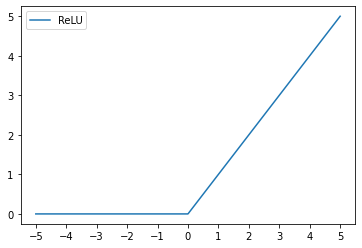

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def relu(x):
    if x > 0:
        return x
    else:
        return 0


check_relu_function(relu)
plot_relu(relu)

Let's try to `jit` this function to speed up compilation and then try to call it.

In [ ]:
relu_jit = jax.jit(relu)

key = jax.random.PRNGKey(42)
# Gen 1000000 random numbers and pass them to relu
num_random_numbers = 1000000
x = jax.random.normal(key, (num_random_numbers,))

# Should raise an error.
try:
    relu_jit(x)
except Exception as e:
    print("Exception {}".format(e))

Exception Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[1000000])>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
The error occurred while tracing the function relu at <ipython-input-21-7a91654ecf1b>:2 for jit. This concrete value was not available in Python because it depends on the value of the argument 'x'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError


**Why does this fail?**


> As mentioned above, JAX transforms first converts python functions into an intermediate language called *jaxpr*. Jaxpr only captures what is executed on the parameters given to it during tracing, so this means during conditional calls, jaxpr only considers the branch taken.
> 
> When jit-compiling a function, we want to compile and cache a version of the function that can handle multiple different argument types (so we don't have to recompile for each function evaluation). For example, when we compile a function on an array `jnp.array([1., 2., 3.], jnp.float32)`, we would likely also want to use the compiled function for `jnp.array([4., 5., 6.], jnp.float32)`. 
> 
> To achieve this, JAX traces your code based on abstract values. The default abstraction level is a ShapedArray - array that has a fixed size and dtype, for example, if we trace a function using `ShapedArray((3,), jnp.float32)`,  it can be reused for any concrete array of size 3, and float32 dtype. 
> 
> This does come with some challenges. Tracing that relies on concrete values becomes tricky and sometimes results in `ConcretizationTypeError` as in the ReLU function above. Furthermore, when tracing a function with conditional statements ("if ..."), JAX doesn't know which branch to take when tracing and so tracing can't occur.

**TLDR**: JAX tracing doesn't work well with conditional statements ("if ..."). 



To solve this, we have two options:
- Use static arguments to make sure JAX traces on a concrete value level - this is not ideal if you need to retrace a lot. Example - bottom of this [section](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#python-control-flow-jit).
- Use builtin JAX condition flow primitives such as [`lax.cond`](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.cond.html) or [`jnp.where`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.where.html).  

**Exercise 1.3 - Code Task** : Let's convert our ReLU function above to work with jit.

**Useful methods:**  [`jnp.where`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.where.html) (or [`jnp.maximum`](https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.maximum.html), if you prefer.) 

In [ ]:
# Implement a jittable ReLU
def relu(x):
    # TODO Implement ME!
    return jnp.maximum(0,x)

In [ ]:
# @title Run to test your function.
check_relu_function(relu)

Your ReLU function is correct!


In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def relu(x):
    return jnp.where(x > 0, x, 0)
    # Another option - return jnp.maximum(x,0)


check_relu_function(relu)

Your ReLU function is correct!


The slowest run took 49.34 times longer than the fastest. This could mean that an intermediate result is being cached.
4.47 ms ± 9.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
188 µs ± 62.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


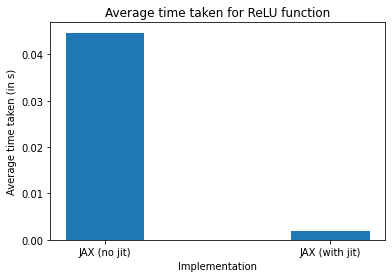

JAX (with jit) was 23.72 times faster than JAX (no jit) !!!


In [ ]:
# @title Now let's see the performance benefit of using jit! (Run me)

# jit our function
relu_jit = jax.jit(relu)

# generate random input
key = jax.random.PRNGKey(42)
num_random_numbers = 1000000
x = jax.random.normal(key, (num_random_numbers,))

# time normal jit function
jax_time = %timeit -o -n 10 relu(x).block_until_ready()

# Warm up/Compile - first run for jitted function
relu_jit(x).block_until_ready()

# time jitted function
jax_jit_time = %timeit -o -n 10 relu_jit(x).block_until_ready()

# Let's plot the performance difference
jax_avg_time = np.mean(jax_time.all_runs)
jax_jit_avg_time = np.mean(jax_jit_time.all_runs)
data = {"JAX (no jit)": jax_avg_time, "JAX (with jit)": jax_jit_avg_time}

plot_performance(data, title="Average time taken for ReLU function")

## Automatic gradient computation

The `grad` transformation is used to automatically compute the gradient of a function in JAX. It can be applied to Python and NumPy functions, which means you can differentiate through loops, branches, recursion, and closures.  

`grad` takes in a function `f` and returns a function. If `f` is a mathematical function $f(x)$, then `grad(f(x))` corresponds to $f'(x)=\frac{df}{dx}$. Then `grad(f)(x_0)` yields $f'(x_0)$.


Let's take a simple function $f(x)=6x^4-9x+4$

In [ ]:
f = lambda x: 6 * x**4 - 9 * x + 4

We can compute the gradient of this function - $f'(x)$ and evaluate it at $x=3$.

In [ ]:
dfdx = grad(f)
dfdx_3 = dfdx(3.0)

**Exercise 1.4 - Math Task**: Can you calculate $f'(2)$ by hand?

In [ ]:
answer = 183  # @param {type:"integer"}

dfdx_2 = dfdx(2.0)

assert (
    answer == dfdx_2
), "Incorrect answer, hint https://en.wikipedia.org/wiki/Power_rule#Statement_of_the_power_rule"

print("Nice, you got the correct answer!")

Nice, you got the correct answer!


In [ ]:
# @title Answer to math task (Try not to run until you've given it a good try!') 
%%latex                                                  
\begin{aligned}
f(x) & = 6x^4-9x+4 \\
f'(x) & = 24x^3 -9  && \triangleright \textrm{Power Rule.}  \\ 
f'(2) &  = 24(2)^3 -9 = 183 && \triangleright \textrm{Substituting x=2} \\
\end{aligned}

<IPython.core.display.Latex object>

We can also chain `grad` to calculate higher order deratives. 

We can calculate $f'''(x)$ as follows:

In [ ]:
d3dx = grad(grad(grad(f)))

**Exercise 1.5 - Math Task**: How about $f'''(2)$ by hand?

In [ ]:
answer = 288  # @param {type:"integer"}

d3dx_2 = d3dx(2.0)

assert answer == d3dx_2, "Incorrect answer, hint ..."

print("Nice, you got the correct answer!")

Nice, you got the correct answer!


In [ ]:
# @title Answer to math task (Try not to run until you've given it a good try!') 
%%latex 

\begin{aligned}
f(x) & = 6x^4-9x+4 \\
f'(x) & = 24x^3 -9  && \triangleright \textrm{Power Rule.}  \\
f''(x) & = 72x^2  && \triangleright \textrm{Power Rule.}  \\
f'''(x) & = 144x && \triangleright \textrm{Power Rule.} \\
f'''(2) & = 144(2)=288 && \triangleright \textrm{Substituting x=2} \\ 
\end{aligned}

<IPython.core.display.Latex object>

Another useful method is `value_and_grad`, where we can get the value ($f(x)$) and gradient ($f'(x)$). 

In [ ]:
from jax import value_and_grad

f_x, dy_dx = value_and_grad(f)(2.0)
print(f"f(x): {f_x} f′(x): {dy_dx} ")

f(x): 82.0 f′(x): 183.0 


> For partial derivatives, you need to use the [`argnums`](https://jax.readthedocs.io/en/latest/_autosummary/jax.grad.html) param to specify which variables you want to differentiate with respect to. 



**Exercise 1.6 - Group Task:** Chat with neighbour/think about how JAX's automatic differentiation compares to other libraries such as Pytorch or Tensorflow. 

Another useful application related to `grad` is when you want your `grad` function to return auxiliary (extra) data, that you don't want differentiated. You can use the `has_aux` parameter to do this (example in "Auxiliary data" section in [here](https://github.com/google/jax/blob/main/docs/jax-101/01-jax-basics.ipynb)).

## Pure Functions

JAX transformation and compilation are designed to work reliably on **pure functions** (see [Wikipedia page on pure functions](https://en.wikipedia.org/wiki/Pure_function)). These functions have the following properties:
1. All **input** data is passed through the **function's parameters**. 
2. All **results** are output through the **function's return**. 
3. The function always returns the same **result** if invoked with the **same inputs**. What if your function involves randomness? Pass in the random seed!
4. **No [side-effects](https://en.wikipedia.org/wiki/Side_effect_(computer_science))** - no mutation of non-local variables or input/output streams.  
 

Let's see what could happen if we don't stick to using pure functions.

### Side Effects

Let's call print within a function.

In [ ]:
def impure_print_side_effect(x):
    print("Print me!")  # This is a side-effect
    return x


# The side-effects appear during the first run
print("First call: ", jax.jit(impure_print_side_effect)(4.0))

Print me!
First call:  4.0


As expected, the print statement is called.

Let's call this function again. 

In [ ]:
# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compilation of the function
print("Second call: ", jax.jit(impure_print_side_effect)(5.0))

Second call:  5.0


Ah, no print statement! Since JAX cached the compilation of the function, `print()` calls will only happen during tracing and not every time the function is called. 

In [ ]:
# JAX re-runs the Python function when the type or shape of the argument changes
print(
    "Third call, different type: ", jax.jit(impure_print_side_effect)(jnp.array([5.0]))
)

Print me!
Third call, different type:  [5.]


In this case, we called the function with a different shaped object and so it triggered the re-tracing of the function and print was called again. 

To print values in compiled functions, use [host callbacks](https://jax.readthedocs.io/en/latest/jax.experimental.host_callback.html?highlight=print#jax.experimental.host_callback.id_print)([example](https://github.com/google/jax/issues/196#issuecomment-1191155679)) or if your jax version>=0.3.16, you can use [`jax.debug.print`](https://jax.readthedocs.io/en/latest/debugging/print_breakpoint.html). 


### Global variables

Using global variables can also lead to some undesired consequences!

In [ ]:
g = 0.0


def impure_uses_globals(x):
    return x + g


# JAX captures the value of the global during the first run
print("First call: ", jax.jit(impure_uses_globals)(4.0))

First call:  4.0


This prints 4, using the original value of `g`.

Let's update `g` and call our function again.

In [ ]:
g = 10.0  # Update the global

# Subsequent runs may silently use the cached value of the globals
print("Second call: ", jax.jit(impure_uses_globals)(4.0))

Second call:  4.0


Even though we updated our global variable, this still prints 4, using the original value of `g`. This is because the value of `g` was cached.

In [ ]:
# JAX re-runs the Python function when the type or shape of the argument changes
# This will end up reading the latest value of the global
print("Third call, different type: ", jax.jit(impure_uses_globals)(jnp.array([4.0])))

Third call, different type:  [14.]


Similar to the side-effects example, re-tracing gets triggered when the shape of our input has changed. In this case, our function now uses the updated value of `g`.

Since the global variables are cached, it is still okay to use global **constants** inside jax functions.

## Function vectorization with vmap

vmap (Vectorizing map) automatically vectorizes your python functions. 

Let's define a simple function that calculates the min and max of an input.

In [ ]:
def min_max(x):
    return jnp.array([jnp.min(x), jnp.max(x)])

We can apply this function to the vector - `[0, 1, 2, 3, 4]` and get the min and max values.

In [ ]:
x = jnp.arange(5)
min_max(x)

DeviceArray([0, 4], dtype=int32)

What about if we want to apply this to a batch/list of vectors (i.e. calculate the min and max independently across multiple batches)? 

Let's create our batch - 3 vectors of size 5.

In [ ]:
batch_size = 3
batched_x = np.arange(15).reshape((batch_size, -1))
print(batched_x)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]]


**Exercise 1.7 - Question**: What do you think would be the result if we passed batch_x into `min_max`?

In [ ]:
batch_min_max_output = [[0,4],[5,9],[10,14]]  # @param ["[[0,4],[5,9],[10,14]]", "[[0,10],[1,11],[2,12],[3,13],[4,14]]", "[0,14]"] {type:"raw"}

assert (batch_min_max_output == np.array(min_max(batched_x))).all(), "Incorrect answer."

print("Nice, you got the correct answer!")

AssertionError: ignored

So the above is not what we want. The `min` and `max` is applied across the entire batch, when we want the min and max per vector/mini-batch. 

We can also manually batch this by `jnp.stack` and a for loop, as follows:

In [ ]:
@jit
def manual_batch_min_max_loop(batched_x):
    min_max_result_list = []
    for x in batched_x:
        min_max_result_list.append(min_max(x))
    return jnp.stack(min_max_result_list)


print(manual_batch_min_max_loop(batched_x))

[[ 0  4]
 [ 5  9]
 [10 14]]


Or, just manually updating the `axis` in `jnp.min` and `jnp.max`. 

In [ ]:
@jit
def manual_batch_min_max_axis(batched_x):
    return jnp.array([jnp.min(batched_x, axis=1), jnp.max(batched_x, axis=1)]).T


print(manual_batch_min_max_axis(batched_x))

These approaches both work, but we need to change our function to work with batches. We can't just run the same code across a batch of data.

There is where `vmap` becomes useful! Using `vmap` we can write a function once, as if it is working on a single element, and then use `vmap` to automatically vectorize it! 

In [ ]:
# define our vmap function using our original single vector function
@jit
def min_max_vmap(batched_x):
    return vmap(min_max)(batched_x)


# Run it on a single vecor
## We add extra dimention in a single vector, shape changes from (5,) to (1,5), which makes the vmapping possible
x_with_leading_dim = jax.numpy.expand_dims(x, axis=0)
print(f"Single vector: {min_max_vmap(x_with_leading_dim)}")

# Run it on batch of vectors
print(f"Batch/list of vector:{min_max_vmap(batched_x)}")

So this is really convenient, but what about performance? 

In [ ]:
batched_x = np.arange(50000).reshape((500, 100))

# Trace the functions with first call
manual_batch_min_max_loop(batched_x).block_until_ready()
manual_batch_min_max_axis(batched_x).block_until_ready()
min_max_vmap(batched_x).block_until_ready()

min_max_forloop_time = %timeit -o -n 10 manual_batch_min_max_loop(batched_x).block_until_ready()
min_max_axis_time = %timeit -o -n 10 manual_batch_min_max_axis(batched_x).block_until_ready()
min_max_vmap_time = %timeit -o -n 10 min_max_vmap(batched_x).block_until_ready()

print(
    f"Avg Times (lower is better) - Naive Implementation: {np.round(np.mean(min_max_forloop_time.all_runs),5)} Manually Vectorized: {np.round(np.mean(min_max_axis_time.all_runs),5)} Vmapped Function: {np.round(np.mean(min_max_vmap_time.all_runs),5)} "
)

So `vmap` should be similar in performance to manually vectorized code (if everything is implemented well), and much better than naively vectorized code (i.e. for loops). 

## Paralelization with pmap

💡**For this subsection, please ensure that colab is using a `TPU` runtime. If no `TPU` runtimes are available, select `Harware Accelerator` - `None` for a cpu runtime.** 

With `pmap` we can convert a function written for a single device to a function that can run in parallel across many devices. 

**Difference between `vmap` and `pmap`**:

So both `pmap` and `vmap` transform a function to work over an array, but they differ in implementation. `vmap` adds an extra batch dimension to all the operations in a function, while `pmap` replicates the function and executes each replica on its own XLA device in parallel.

In [ ]:
# @title Check the device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Let's try and `pmap` a batch of dot products.

Here is an illustration of how we would typically do this sequentially: 

[Source](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/)

In [ ]:
# @title Illustration of Sequential Dot Product (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/not_parallel-2.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

Here is the code implementation of this:

In [ ]:
# Let's generate a batch of size 8, each with a matrix of size (500, 600)

# Let create 8 keys, 1 for each batch
keys = jax.random.split(jax.random.PRNGKey(0), 8)

# Let create our batches
mats = jnp.stack([jax.random.normal(key, (500, 600)) for key in keys])


def dot_product_sequential():
    @jit
    def avg_dot_prod(mats):
        result = []
        # Loop through batch and compute dp
        for mat in mats:
            # dot product between the a mat and mat.T (transposed version)
            result.append(jnp.dot(mat, mat.T))
        return jnp.stack(result)

    avg_dot_prod(mats).block_until_ready()


run_sequential = %timeit -o -n 5 dot_product_sequential()

Here is an illustration of how we would do this in parallel 

[Source](https://www.assemblyai.com/blog/why-you-should-or-shouldnt-be-using-jax-in-2022/)

In [ ]:
# @title Illustration of Parallel Dot Product (Run me)
from IPython.display import HTML

HTML(
    '<iframe width="560" height="315" src="https://www.assemblyai.com/blog/content/media/2022/02/parallelized.mp4" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
)

Here is code implementation of batched dot products:

First, we will create `8` random matrices (one for each available tpu devices - colab tpu's have 8 available [devices](https://cloud.google.com/tpu/docs/system-architecture-tpu-vm) or the 8 cpu cores as we configured).

In [ ]:
# Let create 8 keys, 1 for each batch
keys = jax.random.split(jax.random.PRNGKey(0), 8)

# Each replicated pmapped function get a different key
mats = pmap(lambda key: jax.random.normal(key, (500, 600)))(keys)

The leading dimension here needs to equal the dimension of available devices (since we are sending a batch to each device).

In [ ]:
print(mats.shape)

Using `pmap` to generate the batches ensures these batches are of type `ShardedDeviceArray`. This is similar to an ndarray, except each batch/shared is stored in the memory of multiple devices, so they can be used in subsequent `pmap` operations without moving data around between devices (GPU/TPU) and hosts (cpu). 

In [ ]:
print(type(mats))

In [ ]:
def dot_product_parallel():

    # Run a local matmul on each device in parallel (no data transfer)
    result = pmap(lambda x: jnp.dot(x, x.T))(
        mats
    ).block_until_ready()  # result.shape is (8, 5000, 5000)


run_parallel = %timeit -o -n  5 dot_product_parallel()

It is simple as that. Our dot product now runs in parallel across available devices (cpu, gpus or tpus). As we have more cores/devices, this code will automatically scale! 

In [ ]:
# @title Let's plot the performance difference (Run Cell)

jax_parallel_time = np.mean(run_parallel.all_runs)
jax_seq_time = np.mean(run_sequential.all_runs)


data = {"JAX (seq)": jax_seq_time, "JAX (parallel - pmap)": jax_parallel_time}

plot_performance(data, title="Average time taken for Seq vs Parallel Dot Product")

For some problems, the speed can be directly proportional to the number of devices -- $Nx$ speed up for $N$ devices! 

We showed an example of using `pmap` for *pure* parallelism, where there is no communication between devices. JAX also has various operations for communication across distributed devices ( more on this [here](https://jax.readthedocs.io/en/latest/jax-101/06-parallelism.html#communication-between-devices).)

<hr>

# PART 2 - Optimization using Optax

<hr>

[Optax](https://github.com/deepmind/optax), leverages from the capabilities of JAX, in particular automatic differentiation, to run optimization methods such as vanilla gradient descent, or more advanced ones such as ADAM, on any loss function we may have. 

Below we show how to use Optax to train a simple linear model of the form 

$$y=w\tr x + b,\,w \in \reals^m,\;y,b \in \reals.$$

Below is a little function to simulate noisy samples drawn from a linear model, and a classic mean squared loss function.

In [ ]:
from numpy import random

def sim_linear_model(w, b, num_samples, noise_std=0.05):
  """
  given a linear coefficientw vector w, a bias b and a non-negative integer n
  generate n samples according to y = wx + b + v
  where v is a random Gaussian variable with mean 0
  and standard deviation 0.1
  """
  sample_dim = len(w)
  X = random.uniform(size=(sample_dim,num_samples))
  noise = noise_std*random.normal(size=num_samples)
  y = w @ X + b + noise
  return X,y


def loss(X, y, w, b):
  """
  JAX-based implementation of mean squared loss
  """
  errors = jnp.square(y - w.T @ X - b)
  return jnp.mean(errors)

#
# ground truth
#
w = [0.4]
b = -0.2
#
# draw samples
#
X,y = sim_linear_model(w, b, 100)


## Optax workflow

Since JAX is pure function-based, Optax functions need to be pure functions too. Thus, in order to update the model's parameters, two functions are called in sequence:

1. `optimizer.update(theta,state)` if the model parameters are $\theta$, this function returns the update that needs to be applied to theta in order to obtain a new iterate: $\Delta \theta$. The `state` stores past information gathered by the optimizer which might influence the computation of $\Delta \theta$.
1. `optax.apply(theta,delta_theta)` simply adds `delta_theta` to `theta`

One important aspect of Optax is that it expects the model parameters to be provided as name-value pairs in a dictionary. In the linear model below we have two parameters $w$ and $b$ so that $\theta=(w,b)$ and $\Delta\theta=(\Delta w,\Delta b)$.


In [ ]:
%%capture
!pip install -U optax

import optax
import jax.numpy.linalg as jla

# 
# JAX autograd:  the returned value gloss is a function 
# that computes the gradient of loss(X,y,w,b) with respect to w and b (args 2 and 3)
# 
gloss = jax.grad(loss, argnums=(2,3))


def train_model_optax(X, y, fun, grad, stepsize=1e-2,tolerance=1e-4,maxiter=1000):
  """
  optimization using Optax
  :param X: reference inputs
  :param y: reference output
  :param fun: cost function 
  :param grad: gradient of the cost function
  """
  #
  # create optimizer
  # this guy defines how to update the parameters in each iteration
  #
  optimizer = optax.sgd(stepsize) # TRY other optimizers and stepsizes!! optax.adam
  #
  # initial parameters
  #
  # Optax expects a dictionary parameters
  # in this case we have only one: w
  #
  theta_t = {"w": jnp.zeros(X.shape[0]), "b":jnp.ones(1)}
  #
  # all Optax optimizers have an inner state that needs to 
  # be stored and updated between calls
  #
  state_t = optimizer.init(theta_t)
  
  params     = list()
  costs      = list()
  grad_norms = list()
  #
  # main optimization loop
  #
  for t in range(maxiter):
    #
    # values at current iteration
    #
    w_t = theta_t["w"]
    b_t = theta_t["b"]
    g_t = grad(X,y,w_t,b_t)
    f_t = fun(X,y,w_t,b_t)
    n_t = jla.norm(g_t)
    #
    # check for stopping condition
    #
    if n_t < tolerance:
      break
    #
    # store current solution
    #
    params.append(theta_t)
    costs.append(f_t)
    grad_norms.append(n_t)
    #
    # update solution (here comes Optax)
    #
    # Optax expects a dictionary of gradients, one per parameter
    # corresponding to the dictionary of parameters above
    #
    g_t = {"w":g_t[0],"b":g_t[1]} 
    d_t, state_t = optimizer.update(g_t, state_t)
    theta_t = optax.apply_updates(theta_t, d_t)

  return params,costs,grad_norms


    

### Running our optax-powered optimizer

Run the cell below to see our latest method in action.

<hr>

**ExcerciseL** try again, now changing the optimizer and/or the stepsize (see [Common Optimizers](https://optax.readthedocs.io/en/latest/api.html) ). One popular one is ADAM (`optax.adam`)


In [ ]:
def plot_trajectory(params,costs,norms):
  """
  helper function for plotting our thing
  """
  niter = len(costs)

  plt.figure(figsize=(15,5))

  plt.subplot(1,3,1)
  plt.semilogy(costs)
  plt.xlabel('iteration')
  plt.ylabel('loss')
  plt.title('evolution of loss across iterations')
  plt.grid(True)

#
# call the algorithm
#
params,costs,norms = train_model_optax(X, y, loss, gloss,stepsize=0.1)

plot_trajectory(params,costs,norms)

<hr>

# PART 3 - Training Models with Haiku

<hr>

So far we've seen how to use JAX and Optax to implement an optimization loop.
Thanks to these two libraries, we can exploit our computing resources to the maximum, forget about computing gradients by hand, and to define the descent direction altogether.

What if we now want to build a deep neural model? If we want to do it with JAX, we need JAX-enabled blocks (dense, convolutional, relus, maxpool, etc.) and a way to construct and maintain the state of the resulting mammoth.

Here's where [Haiku](https://github.com/deepmind/dm-haiku) comes in, by providing a JAX-based alternative to those familiar with  the traditional Pytorch or Tensorflow libraries.

## Haiku is object oriented

Haiku is an *object-oriented* library, meaning that our models, their parameters, etc., are represented as _instances_ of _object classes_. If you are not familiar with object oriented programming, you should learn this concept first. There are many tutorials on the subject ([example](https://realpython.com/python3-object-oriented-programming/)).

## JAX is functional oriented

However, there is a twist, as JAX follows the  _functional programming_ paradigm! 

Haiku modules are similar to standard python objects (they have references to their own parameters and functions). However, since JAX operates on *pure functions*, Haiku modules **cannot be directly instantiated**, but rather they need to be **wrapped into pure function transformations.**

So, the overall rationale is to:

* write an object for your model
* wrap the object so that it is seen by JAX as a set of pure functions

Don't worry. It sounds more complicated than it is.

In [ ]:
%%capture
#@title Run this cell to install Haiku!
!pip install -U dm-haiku


## Wrapping a model in Haiku

We'll now create a linear model in the way of Haiku. This linear model contains another parameter `b`, a constant (bias) term that is added to the linear combination, so that $y=wx+b$.

The core object in Haiku is a `Module`. A module contains parameters and a function `__call__` that combines these parameters and user input to produce an output. This is what we could call a `block` within a Neural Network.



In [ ]:
import haiku as hk

class MyLinearModel(hk.Module): # notice: model inherits from haiku.Module
  """
  Haiku-based linear model of the form y=w*x+b

  A Haiku module is expected to implement __call__ in order to produce
  its output.
  """
  
  def __init__(self, output_dim, name=None):
    """
    :param output_dim: dimension of the model output (y)
    """
    super().__init__(name=name)
    self.output_dim = output_dim


  def __call__(self, x):
    """
    special function, gets called when we use the () operator on an instance
    """
    j, k = x.shape[-1], self.output_dim
    #
    # note: the three lines below are actually called *once* and serve
    # to declare and initialize the parameters of the model.
    # 
    w_init = hk.initializers.TruncatedNormal(1.0 / np.sqrt(j))
    w = hk.get_parameter("w", shape=[j, k], dtype=x.dtype, init=w_init)
    b = hk.get_parameter("b", shape=[k], dtype=x.dtype, init=jnp.ones)
    #
    # this is the actual code that's executed when the module is called
    #
    return jnp.dot(x, w) + b

### Wrapping the Module

In order for a module to be used by JAX, it needs to be treated not as an object, but as a set of pure functions plus a _state_, which has to be explicitly fed to the functions.

The wrapping is done by the Haiku `transform` function. This wrapper takes a **function** of one or more Haiku Modules (not just any class) and "eviscerates" the modules it to bring out the parameters. 

In order for Haiku to know which parameters each  module has, the parameters need to be explicitly created and initialized using `hk.get_parameter`. In the module above, this is done in the `__call__` functions. 

(Admittedly, this is rather counter-intuitive, as it would seem that the parameters are created and initialized each time the `__call__` function is called. Also, they are not in the `__init__` method, which is the natural place for initializing things in an object. )

So, the wrapping goes in two stages:

1. we wrap the model (module) into a function
1. we transform the function to obtain two other functions:
   * an `init` function, that serves to initialize the parameters
   * an `apply` function, which calls the function with the parameters

In [ ]:
#
# first step: wrap the module in a function
#
def model_fn(x):
  """
  wrapper function for our model
  """
  module = MyLinearModel(output_dim=1)
  return module(x)

#
# second step: transform the function into a pair (init,apply)
# 
wrapped_model = hk.transform(model_fn)
print(wrapped_model)


## Different flavours of transformation

As you may know from our previous tutorial on JAX, pseudo-random numbers play a central role in JAX and, because of the pure function concept, their state needs to be passed explicitly anywhere they're used.

With this in mind, the functions produced by `hk.transform` include the PRNG state explicitly as their first argument in all calls, as can be seen in the  signature of the wrapper functions returned by `hk.transform`:

* `init(prng,data)`
* `apply(prng,params,data)`

If we don't want or don't need to use a PRNG, we can ask for a different set of wrapper functions which do not include the PRNG as an argument. In our case, our `init` function does use PRNG since the weights are initialized randomly through `hk.initializers.TruncatedNormal`, but  our module's output is deterministic ($y=wx+b$). Accordingly, we'd like our signatures to be:

* `init(prng)`
* `apply(params,input)`

This is achieved by calling `hk.without_apply_rng` to our transformed model:

In [ ]:
#
# transform again to obtain another pair 
#
wrapped_model = hk.without_apply_rng(wrapped_model)
#
# inspect the output and notice how the `apply` function has changed 
# compared to the previous value
#
print(wrapped_model)

### Test the wrapper model

Let's see how the wrapped model works.


In [ ]:
#
# input dimention we are considering
#
input_dim = 3
#
# evaluate our model somewhere
#
some_x= jnp.arange(input_dim, dtype=jnp.float32)
print(some_x)
#
# initialize PRNG, a must in JAX
#
rng_key = jax.random.PRNGKey(42)
#
# initialization DOES use the PRNG, and (possibly) the data too
#
params = wrapped_model.init(rng=rng_key, x=some_x)
print(params)
#
# try it out
#
print(wrapped_model.apply(params,some_x))


# Training with Haiku and Optax


Here we show a full training loop, using Haiku and Optax. For convenience, we introduce structures like `TrainingState` and functions like `init`,`update` and `loss_fn`. Please read through to get comfortable with how you can effectively train JAX models.

In [ ]:
#@title Load packages
%%capture
# need to install this for plotting.
!pip install optax
!pip install dm-haiku
#
# packages
#
from typing import Any, MutableMapping, NamedTuple, Tuple
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split
import haiku as hk
import optax


In [ ]:
# @title Define and wrap our model

class MyLinearModel(hk.Module): # notice: model inherits from haiku.Module
  """
  Haiku-based linear model of the form y=w*x+b

  A Haiku module is expected to implement __call__ in order to produce
  its output.
  """
  
  def __init__(self, output_dim, name=None):
    """
    :param output_dim: dimension of the model output (y)
    """
    super().__init__(name=name)
    self.output_dim = output_dim


  def __call__(self, x):
    """
    special function, gets called when we use the () operator on an instance
    """
    j, k = x.shape[-1], self.output_dim
    #
    # note: the three lines below are actually called *once* and serve
    # to declare and initialize the parameters of the model.
    # 
    w_init = hk.initializers.TruncatedNormal(1.0 / np.sqrt(j))
    w = hk.get_parameter("w", shape=[j, k], dtype=x.dtype, init=w_init)
    b = hk.get_parameter("b", shape=[k], dtype=x.dtype, init=jnp.ones)
    #
    # this is the actual code that's executed when the module is called
    #
    return jnp.dot(x, w) + b

#
# wrap the model into a function
#
def model_fn(x):
  """
  same wrapper function for Haiku modules, repeated for clarity
  """
  module = MyLinearModel(output_dim=1)
  return module(x).ravel()
#
# transform using Haiku as a pair init,apply
#
model = hk.without_apply_rng(hk.transform(model_fn))


In [ ]:
from jax import random as jrand
from jax.numpy import linalg as jla

def loss_fun_haiku(params: hk.Params, X, y):
  """
  our loss function
  """
  y_pred = model.apply(params, X)
  return jnp.mean((y_pred - y) ** 2)


def train_model_haiku(X, y, model, loss_fun, stepsize=1e-3,tolerance=1e-4,maxiter=1000,seed=42):
  """
  optimization using Optax
  :param X: reference inputs
  :param y: reference output
  :param fun: cost function 
  :param grad: gradient of the cost function
  """
  #
  # create optimizer
  # this guy defines how to update the parameters in each iteration
  #
  optimizer = optax.sgd(stepsize) # TRY other optimizers and stepsizes!! optax.adam
  #
  # initialization
  #
  rng = jrand.PRNGKey(seed)
  rng, init_rng = jrand.split(rng)
  theta_t       = model.init(init_rng, X)
  state_t       = optimizer.init(theta_t)
  
  params     = list()
  losses     = list()
  grad_norms = list()
  #
  # main optimization loop
  #
  for t in range(maxiter):
    #
    # values at current iteration
    #
    loss_t, gtheta_t  = jax.value_and_grad(loss_fun)(theta_t, X, y)
    n_t = jnp.sqrt(jnp.sum(jnp.square(gtheta_t["my_linear_model"]["w"])) + jnp.sum(jnp.square(gtheta_t["my_linear_model"]["b"])))
    #
    # check for stopping condition
    #
    if t > 0 and t % 100: 
      print(n_t)
      
    if n_t < tolerance:
      break
    #
    # store current solution
    #
    params.append(theta_t)
    losses.append(loss_t)
    grad_norms.append(n_t)
    #
    # update solution (here comes Optax)
    #
    dtheta_t, state_t = optimizer.update(gtheta_t, state_t)
    theta_t           = optax.apply_updates(theta_t, dtheta_t)

  return params,losses,grad_norms


params,losses,norms = train_model_haiku(X, y, model, loss_fun_haiku, stepsize=1e-2)

plot_trajectory(params,losses,norms)
    


<hr>

# PART 4 - Convolutional Neural Networks

<hr>

We have seen how to create and train a simple model using Haiku. Now we will use the built in models and blocks of Haiku to create and train a deep convolutional network. In the process, we will learn about convolutional networks, one of the core blocks in modern neural models.




In [1]:
#@title Module Prerequisites (run if you skipped previous modules)
!pip install optax # repeated install, if you want to run just PART 3
!pip install dm-haiku 

import jax.numpy as jnp
import numpy as np


import os # for file i/o

#
# basic libraries
#
import numpy as np
import matplotlib.pyplot as plt
#
# JAX, Optax and Haiku
#
import jax
from jax import numpy as jnp
from jax import random as jrand
from jax.numpy import linalg as jla
from jax import grad, jit, vmap, pmap

import optax

import haiku as hk

import tensorflow as tf # for the datasets


# https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
if int(os.environ["COLAB_GPU"]) > 0:
    print("a GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
    import jax.tools.colab_tpu

    jax.tools.colab_tpu.setup_tpu()
else:
    print("Only CPU accelerator is connected.")
    # x8 cpu devices - number of (emulated) host devices
    os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Only CPU accelerator is connected.


## Preliminaries - color image representation

As you may know, there are different types of digital images. The simplest ones are grayscale images, where a pixel is a single scalar value (e.g., 254) where the value 0 is black and the value 255 is white (if pixels are floating point values, the convention is that 0.0 is black and 1.0 is white). 

In general, however, an image can have several _channels_. Typical color images have three channels: red, green and blue (RGB - generally in that order). In such cases, an RGB pixel's value is a _vector_ of three values `[r,g,b]`.

More generally, an _hyperspectral image_ (e.g., with infrared bands) can have any number of channels.

The convention used in Python image processing/computer vision/machine learning libraries is to represent images as _three-dimensional tensors_. There are two conventions:  _channels first_ and _channels_last_. As the name implies, a _channels first_ image is a $c{\times}h{\times}w{\times}$ array where $h$ and $w$ are the height and width of the image, and $c$ is the number of channels. So for example, a typical 640x480 RGB image will have dimensions 3x640x480.

The more common convention is the _channels last_ one. In this case, a 640x480 image will have dimension 640x480x3, where the _last_ index indicates the channel.


## Color images as network inputs

As input data, even small images are huge. To see this, consider a simple, shallow network with a single fully connected layer of 500 neurons whose inputs are 100x100 RGB images: **how many parameters would this network have?**. Do this calculation  before continuing!

## Convolutional layers

**CONTINUE: this text below can be greatly improved**

ConvNets address this model parameter issue by exploiting structure in the inputs to the network (in particular, by making the assumption that the input is a 3-D *volume*, which applies to images for example, where the 3 dimensions consist of the three RGB channels). The two key differences between a ConvNet and a Feed-forward network are:

* ConvNets have neurons that are arranged in 3 dimensions: width, height, depth. Note that *depth* here means channels, i.e. the depth of the input volume, not the depth of a deep neural network!
* The neurons in each layer are only connected to a small region of the layer before it.

**QUESTION**: Unfortunately there is no such thing as a free lunch. What trade-off do you think a ConvNet makes for the reduction in memory required by fewer parameters?

Generally, a ConvNet architecture is made up of different types of layers, the most common being convolutional layers, pooling layers and fully-connected layers that we encountered in the last practical.

## Optional reading: The rise of deep convolutional architectures

ConvNet architectures were key to the tremendous success of deep learning in machine vision. In particular, the first deep learning model to win the ImageNet competition in 2012 was called AlexNet (after Alex Krizhevsky, one of its inventors). It had 5 convolutional layers followed by 3 fully-connected layers. Later winners included GoogLeNet and ResNet. If you're curious, have a look at [this link](https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba) for a great summary of different ConvNet architectures.

## Convolutional layer architecture

A 2-dimensional convolutional layer maps an input *volume* (meaning, a 3-D input tensor, e.g. [width, height, channels]) to an output *volume* through a set of learnable filters, which make up the parameters of the layer. Every filter is small spatially (along width and height), but extends through the full depth of the input volume. (Eg: A filter in the first layer of a ConvNet might have size [5, 5, 3]). During the forward pass, we convolve ("slide") each filter across the width and height of the input volume and compute element-wise dot products between the entries of the filter and the input at any position. As we slide the filter over the width and height of the input volume we will produce a 2-dimensional activation map that gives the responses of that filter at every spatial position. Each convolutional layer will have such a set of filters, and each of them will produce a separate 2-dimensional activation map. We then stack these activation maps along the depth-dimension to produce the output volume.

By using these filters which map to a small sub-volume of the input, we can to a large extent, control the parameter explosion that we would get with a (fully-connected) feed-forward network. This **parameter sharing** actually also tends to improve the performance of the model on inputs like natural images because it provides the model with some limited **translation invariance**. Translation invariance means that if the image (or a feature in the image) is translated (moved), the model will not be significantly affected. Think about why this is the case!

The following animation illustrates these ideas, make sure you understand them!

![Convolution Animation](https://i.stack.imgur.com/FjvuN.gif)

If the parameter sharing aspect of CNNs is still not clear, consider the following diagram which compares a simplified 1-D convolutional layer with a fully-connected layer. The diagram shows how a 1-dimensional input  $\mathbf{x}$ is mapped to a 1-dimensional output  $\mathbf{y}$ using both a fully-connected layer and a convolution layer, both without bias parameters. The colours of the edges represent the value of the weight parameters in the layers. For the fully-connected layer, the number of weights is the product of the input and output sizes, in this case, $6 \times 4 = 24$. On the other hand, the number of weights in the convolutional layer depends only on the filter size of the convolution, in this case, $3$, and is independent of the input and output sizes.

![Weight Sharing](https://i.imgur.com/gcmmZz4.png)


The hyper-parameters of a convolutional layer are as follows:
* **Filters** defines the number of filters in the layer
* **Kernel Size** defines the width and height of the filters (also called "kernels") in the layer. Note that kernels always have the same depth as the inputs to the layer.
* **Stride** defines the number of pixels by which we move the filter when "sliding" it along the input volume. Typically this value would be 1, but values of 2 and 3 are also sometimes used.
* **Padding** refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.



## Optional reading: Building complex filters

One of the reasons that CNNs have been so successful is their ability to build up complex filters by composing more simple filters. For example, imagine a 5 layer CNN that has been trained to detect faces. The first 4 layers are convolutional and the last layer is fully-connected and outputs the final prediction (is there a face or not). We might find that the filters in each convolution layer pick out the following features:

1. lines (horizontal, vertical, diagonal), and colour gradients,
2. corners, circles and other simple shapes, and simple textures,
3. noses, mouths, and eyes,
4. whole faces.

The neural net has learned to pick out complex objects like facial features and even whole faces! The reason for this is that each successive layer can combine the filters from the previous layer to detect more and more sophisticated features. The following diagram (adapted from [this paper](http://web.eecs.umich.edu/~honglak/icml09-ConvolutionalDeepBeliefNetworks.pdf)) shows some really cool examples of this kind of behaviour. The lower level features (shown above) detect noses, eyes, and mouths, in the case of faces, and wheels, doors, and windows, for cars. The higher level features are then able to detect whole faces and cars.

![Imgur](https://i.imgur.com/653uIty.jpg)

The diagrams on page 7 of [this classic paper](https://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) show more examples of this phenomena and are definitely worth checking out!

## (Max) Pooling
A pooling layer reduces the spatial size of the representation. There are different reasons why we may want to do this. One is to reduce the number of parameters in the network. Imagine a convnet for the MNIST dataset. If the feature tensor produced by the final conv/pool/relu layer was say, of size 20x20 and had 100 feature channels, the final dense layer would have 20x20x100x10=400k parameters. However, if we down-sampled that layer to a 4x4 spatial size, we would have only 20k parameters. A big difference!

Another reason is that we want later features (deeper in the network) to have larger *receptive fields* (input regions that they look at), in order to represent bigger objects and object parts for instance. In particular, pooling stride gives later features much larger receptive fields so that they can effectively combine smaller features together.

A pooling layer has no trainable parameters. It applies some 2-D aggregation operation (usually a max(), but others like average() may also be used) to regions of the input volume. This is done independently for each depth dimension of the input. For example, a 2x2 max pooling operation with a stride of 2, downsamples every depth slice of the input by 2 along both the width and height.

The hyper-parameters of a pooling layer are as follows:
* `window_shape` how many values are aggregated together.
* `stride` defines the number of pixels by which we move the pooling filter when sliding it along the input. Typically this value would be equal to the pool size.
* `padding` refers to the addition of 0-value pixels to the edges of the input volume along the width and height dimensions. In Tensorflow you can set this to "VALID", which essentially does no padding or "SAME" which pads the input such that the output width and height are the same as the input.

#### Question
Do 2x2 max-pooling by hand, with a stride of 2, and "VALID" padding, on the following 2D input. What is the size of the output?

\begin{bmatrix}
  9 & 5 & 4 & 5 & 6 & 4 \\
  6 & 6 & 3 & 5 & 8 & 2 \\
  4 & 6 & 9 & 1 & 3 & 6 \\
  9 & 7 & 1 & 5 & 8 & 1 \\
  4 & 9 & 9 & 5 & 7 & 3 \\
  7 & 3 & 6 & 4 & 9 & 1 
\end{bmatrix}


Reveal the cell below by double-clicking and running it, to check your answer when you're done!

In [2]:
#@title Answer { display-mode: "form" }
#import numpy as np
#import
X = np.array([[9, 5, 4, 5, 6, 4],
              [6, 6, 3, 5, 8, 2],
              [4, 6, 9, 1, 3, 6],
              [9, 7, 1, 5, 8, 1],
              [4, 9, 9, 5, 7, 3],
              [7, 3, 6, 4, 9, 1]])

def max_pool_fun(x):
  mp = hk.MaxPool(window_shape=(2, 2), strides=2, padding='VALID')
  return mp(x)

max_pool = hk.without_apply_rng(hk.transform(max_pool_fun))
params = max_pool.init(None,X)
print('pooled:\n',max_pool.apply(params,X))


pooled:
 [[9 6 5 8 8]
 [6 9 9 8 8]
 [9 9 9 8 8]
 [9 9 9 8 8]
 [9 9 9 9 9]]


## Optional reading: Receptive fields

Earlier we mentioned that one reason to do pooling is to increase the sizes of the receptive fields of our features. Let's take a closer look at what we meant by this. 

The diagram below shows the effective receptive field of one output "neuron" in each layer of a few simple networks. What the diagram tells us is how many of the input values have an effect on each output value.

We can see that in the first two examples, with single convolutional layers, the receptive field is simply equal to the kernel size. 

However, the next two examples are a little more interesting. Here we have drastically increased the receptive field size, without a large increase in the number of parameters, by stacking convolution and pooling layers. The interesting thing here is that by using a pooling layer we increased our receptive field size by a much smaller cost (in the number of parameters) than if we'd simply increased the kernel sizes of our convolution layers.

You can read more about receptive fields [here](https://medium.com/mlreview/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807).


![Receptive Fields](https://i.imgur.com/TjxEsG4.png)


## The CIFAR10 Dataset
Now that we understand convolutional, max-pooling and feed-forward layers, we can combine these as building blocks to build a ConvNet classifier for images. For this practical, we will use the colour image dataset CIFAR10 (pronounced "seefar ten") which consists of 50,000 training images and 10,000 test images. As we did in Practical 1, we take 10,000 images from the training set to form a validation set and visualise some example images.

In [7]:
cifar = tf.keras.datasets.cifar10
(all_train_images, all_train_labels), (all_test_images, all_test_labels) = cifar.load_data()
all_test_images = all_test_images.astype(float)*(1/255)
all_train_images = all_train_images.astype(float)*(1/255)

cifar_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [12]:
# Take the last 10000 images from the training set to form a validation set
ntrain = 10000
ntest = 1000

all_train_labels = all_train_labels.squeeze()
train_images = all_train_images[:ntrain, :, :, :]
train_labels = all_train_labels[:ntrain]

all_test_labels = all_test_labels.squeeze()
test_images = all_test_images[-ntest:, :, :, :]
test_labels = all_test_labels[-ntest:]
#
# convert to JAX
#
X_train, X_test, Y_train, Y_test = jnp.array(train_images, dtype=jnp.float32),\
                                   jnp.array(test_images,  dtype=jnp.float32),\
                                   jnp.array(train_labels, dtype=jnp.float32),\
                                   jnp.array(test_labels,  dtype=jnp.float32)

classes =  jnp.unique(Y_train)


What are the shapes and data-types of train_images and train_labels?

In [13]:
print('train_images.shape = {}, data-type = {}'.format(X_train.shape, X_train.dtype))
print('train_labels.shape = {}, data-type = {}'.format(Y_train.shape, Y_train.dtype))
print('train_images.shape = {}, data-type = {}'.format(X_test.shape, X_test.dtype))
print('train_labels.shape = {}, data-type = {}'.format(Y_test.shape, Y_test.dtype))


train_images.shape = (10000, 32, 32, 3), data-type = float32
train_labels.shape = (10000,), data-type = float32
train_images.shape = (1000, 32, 32, 3), data-type = float32
train_labels.shape = (1000,), data-type = float32


### Visualise examples from the dataset
Run the cell below multiple times to see various images. (They might look a bit blurry because we've blown up the small images.)

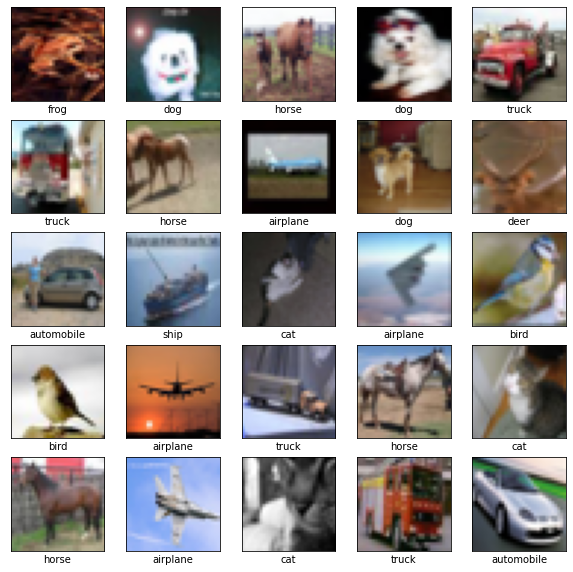

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  img_index = np.random.randint(0, 10000)
  plt.imshow(train_images[img_index])
  plt.xlabel(cifar_labels[train_labels[img_index]])

## A ConvNet Classifier
Finally, we build a simple convolutional architecture to classify the CIFAR images. We will build a mini version of the AlexNet architecture, which consists of 5 convolutional layers with max-pooling, followed by 3 fully-connected layers at the end. In order to investigate the effect each of these two layers has on the number of parameters, we'll build the model in two stages. 

First, the convolutional layers + max-pooling:

In [15]:
#@title Create Network, Haiku way

#
# Haiku module
#
class ConvNetModule(hk.Module):

  def __init__(self):      
    """
    add some layers to the net
    """
    super().__init__(name="ConvNetModule")
    initializer  = hk.initializers.VarianceScaling(1.0,"fan_avg","truncated_normal") # Glorot
    self.conv1   = hk.Conv2D(output_channels=48, kernel_shape=(3,3), padding="SAME",w_init=initializer)    
    self.pool1   = hk.MaxPool(window_shape=(3,3),strides=(1,1),padding="SAME")

    self.conv2   = hk.Conv2D(output_channels=128, kernel_shape=(3,3), padding="SAME",w_init=initializer)
    self.pool2   = hk.MaxPool(window_shape=(3,3),strides=(1,1),padding="SAME")
    
    self.conv3_1 = hk.Conv2D(output_channels=192, kernel_shape=(3,3), padding="SAME",w_init=initializer)    
    self.conv3_2 = hk.Conv2D(output_channels=192, kernel_shape=(3,3), padding="SAME",w_init=initializer)    
    self.conv3_3 = hk.Conv2D(output_channels=128, kernel_shape=(3,3), padding="SAME",w_init=initializer)    
    self.pool3 = hk.MaxPool(window_shape=(3,3),strides=(1,1),padding="SAME")

    self.flatten = hk.Flatten()
    self.linear1 = hk.Linear(output_size=1024,w_init=initializer) # was 1024

    self.linear2 = hk.Linear(output_size=1024,w_init=initializer) # was 1024, reduced due to OOM
    self.linear3 = hk.Linear(output_size=len(classes),w_init=initializer)


  def __call__(self, x_batch):
    """
    apply the network to given inputs
    """

    x = self.conv1(x_batch)
    x = jax.nn.relu(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = jax.nn.relu(x)
    x = self.pool2(x)

    x = self.conv3_1(x)
    x = self.conv3_2(x)
    x = self.conv3_3(x)
    x = self.pool3(x)

    x = self.flatten(x)
    x = self.linear1(x)
    
    coin = hk.next_rng_key()
    x = hk.dropout(coin,0.5,x)
    x = jax.nn.relu(x)

    x = self.linear2(x)
    x = jax.nn.relu(x)

    x = self.linear3(x)
    x = jax.nn.softmax(x)

    return x

#
# wrap it into a function
#
def cnn_fun(x):
    cnn = ConvNetModule()
    return cnn(x)

#
# transform into functional pair: init, apply
#
conv_net = hk.transform(cnn_fun) 

#
# define the network loss
#
def cnn_loss(weights, key, input_data, actual):
  preds = conv_net.apply(weights, key, input_data)
  one_hot_actual = jax.nn.one_hot(actual, num_classes=len(classes))
  log_preds = jnp.log(preds)
  return - jnp.sum(one_hot_actual * log_preds)


### Optional reading: initialization schemes

You might have wondered what values we are using for the initial values of the weights and biases in our model. The short answer is that we typically use random initialization. In this case, we have just been using the default Keras initializers for each layer, which are usually sufficient.

The longer answer is that just using completely random numbers does not always work best in practice and that there are a number of common initialization schemes (which are available in most deep learning frameworks such as TensorFlow and Keras).

Let's consider a few examples:

 * When using the ReLU activation it is common to initialize the biases with small positive numbers because this encourages the ReLU activations to start off in the _on_ state, which helps to counteract the _dying ReLU problem_.

 * The deeper neural networks become the more likely it is that gradients will either shrink to the point that they vanish, or grow to the point that they overflow (the _vanishing_ and _exploding_ gradients problems). To help combat this we can initialize our weights to have a (model-specific) appropriate scale. One method for doing this is called [Xavier or Glorot](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialization.

 * The _Xavier_ initialization scheme was designed with the _traditional_ activations Sigmoid and TanH in mind and does not work as well for ReLU activations. An alternative is [He or Kaiming](https://arxiv.org/pdf/1502.01852.pdf) initialization which is a modification of Xavier initialization for ReLU activations.

 [This blog](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization) goes into more detail on _He_ and _Xavier_ initialization. [The Keras documentation](https://keras.io/initializers/) lists a number of common schemes. 

### Training and Validating the model
In the last practical we wrote out the dataset pipeline, loss function and training-loop to give you a good appreciation for how it works. This time, we use the training loop built-in to Keras. For simple, standard datasets like CIFAR, doing it this way will work fine, but it's important to know what goes on under the hood because you may need to write some or all of the steps out manually when working with more complex datasets! 

In [16]:
import time

def train_cnn_haiku(_train_data, _model, _loss_fun, 
                    _stepsize=1e-4,_tolerance=1e-3,
                    _epochs=25, _batch_size=200, _seed=42):
  """
  optimization using Optax
  :param _train_data: tuple (X_train,y_train,X_test,y_test)
  :param _model: target model to be optimized
  :param _loss_fun: loss function
  :param _stepsize: how fast should we update parameters
  :param _tolerance: if performance does not improve at least this ratio, stop
  :param _batch_size: how many samples to evaluate at each batch
  :param _seed: random seed. If you don't know why this is 42, read the Hitchhiker's Guide to the Galaxy by Douglas Adams
  """
  _X_train, _y_train, _X_val, _y_val = _train_data
  #
  # create optimizer
  # this guy defines how to update the parameters in each iteration
  # try others! https://optax.readthedocs.io/en/latest/api.html
  #
  _optimizer = optax.adam(_stepsize)
  #
  # initialization
  # note: handling random numbers in jax is delicate
  # you have to carry the next key yourself
  # see https://jax.readthedocs.io/en/latest/jax-101/05-random-numbers.html
  #
  _key = jrand.PRNGKey(_seed)
  _key, _subkey = jrand.split(_key) 
  #
  # initial model parameters
  #
  _theta_t       = _model.init(_subkey, _X_train[:5,:])
  #
  # initial optimizer state
  #
  _state_t       = _optimizer.init(_theta_t)
  
  _nsamples = _X_train.shape[0]
  _indexes = jnp.arange(_nsamples)
  _nbatch = int(np.ceil(_nsamples / _batch_size))
  _batches = list(_batch_size*i for i in range(_nbatch))
  _batches.append(None) # tail

  print('total number of samples:',_nsamples)
  print('number of batches:',_nbatch)
  print('batch size:',_batch_size)

  _loss_history  = list()
  #
  # epochs
  #
  for t in range(_epochs):
    #
    # perform a number of batches
    #
    t0 = time.time()
    _train_losses = list()
    _val_losses   = list()
    for i in range(_nbatch):
      print('.',end='',flush=True)
      _X_batch = _X_train[_batches[i]:_batches[i+1],:]
      _y_batch = _y_train[_batches[i]:_batches[i+1]]
      #del batch_idx
      #
      # current iterate
      #
      _key,_subkey = jrand.split(_key)
      _train_loss_t, _grad_t  = jax.value_and_grad(_loss_fun)(_theta_t, _key, _X_batch, _y_batch)
      _val_loss_t             = _loss_fun(_theta_t, _key, _X_val, _y_val)
      _train_losses.append(_train_loss_t)
      _val_losses.append(_val_loss_t)
      del _X_batch,_y_batch
      #
      # optimization may go bananas for large stepsize
      #
      if np.isnan(_train_loss_t):
        print(f"training became unstable! Try using a step size smaller than {_stepsize}.")
        return None
      #
      # update iterate
      #
      _update_t, _state_t = _optimizer.update(_grad_t, _state_t) 
      del _grad_t
      _theta_t = optax.apply_updates(_theta_t, _update_t)
      del _update_t
    #
    # average loss throughout epoch
    #
    _mean_train_loss = np.mean(np.array(_train_losses))
    _std_train_loss  = np.std( np.array(_train_losses))
    _mean_val_loss   = np.mean(np.array(_val_losses))
    _std_val_loss    = np.std( np.array(_val_losses))
    print(f'epoch {t:5} train loss {_mean_train_loss:10.5f} +/- {_std_train_loss:10.5f}',end=' ')
    print(f'epoch {t:5} val loss {_mean_val_loss:10.5f} +/- {_std_val_loss:10.5f}',end=' ')
    print(f'batch time {dt}')
    loss_history.append((_mean_train_loss,_std_train_loss,_mean_val_loss,_std_val_loss))
    dt = time.time() - t0
    #
    # update solution (here comes Optax)
    #

  return _theta_t,loss_history

#
# run optimization
#
train_data = X_train, Y_train, X_test, Y_test
theta,loss_history = train_cnn_haiku(train_data, conv_net, cnn_loss)

    


total number of samples: 10000
number of batches: 50
batch size: 200
..

KeyboardInterrupt: ignored

### Classifying examples
We now use our trained model to classify a sample of 25 images from the test set. We pass these 25 images to the  ```model.predict``` function, which returns a [25, 10] dimensional matrix. The entry at position $(i, j)$ of this matrix contains the probability that image $i$ belongs to class $j$. We obtain the most-likely prediction using the ```np.argmax``` function which returns the index of the maximum entry along the columns. Finally, we plot the result with the prediction and prediction probability labelled underneath the image and true label on the side. 

In [ ]:


classes =  jnp.unique(Y_train)

img_indices = np.random.randint(0, len(test_images), size=[25])
X_sample = test_images[img_indices]
Y_sample = [cifar_labels[i] for i in test_labels[img_indices].squeeze()]

rng = jax.random.PRNGKey(42)
#
#
#
Y_pred = np.zeros((ntrain))
for i in range(ntrain):
  Y_pred[i] = conv_net.apply(theta, rng, X_train[i,:])

max_prediction = np.argmax(Y_pred, axis=1)
prediction_probs = np.max(Y_pred, axis=1)

In [ ]:
plt.figure(figsize=(10,10))
for i, (img, prediction, prob, true_label) in enumerate(
    zip(X_sample, max_prediction, prediction_probs, Y_sample)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid('off')

  plt.imshow(img)
  plt.xlabel('{} ({:0.3f})'.format(cifar_labels[prediction], prob))
  plt.ylabel('{}'.format(true_label))


### Question
What do you think of the model's predictions? Looking at the model's confidence (the probability assigned to the predicted class), look for examples of the following cases:
1. The model was correct with high confidence
2. The model was correct with low confidence
3. The model was incorrect with high confidence
4. The model was incorrect with low confidence

What do you think the (relative) loss values would be in those cases? 


### Optional extra reading: Uncertainty in deep learning

Deep neural networks are not considered to be very good at estimating the uncertainty in their predictions. However, knowing your model's uncertainty can be very important for many applications. For example, consider a deep learning tool for diagnosing diseases, in this case, a false negative could have massive impacts on a person's life! We would really like to know how confident our model is in its prediction. This is a budding field of research, for example, see [this blog](https://www.cs.ox.ac.uk/people/yarin.gal/website/blog_3d801aa532c1ce.html) for a nice introduction.

### Optional extra reading: CNN architectures

Deciding on the architecture for a CNN, i.e. the combination of convolution, pooling, dense, and other layers, can be tricky and often can seem arbitrary. On top of that, one also has to make decisions such as what kind of pooling, which activation functions, and what size of convolution to use, among other things. For new and old practitioners of deep learning, these choices can be overwhelming. 

However, by examining existing successful CNN architectures we can learn a lot about what works and what doesn't. (We can even apply these existing architectures to our problems since many deep learning libraries, such as TensorFlow and Keras, have them [built in](https://keras.io/applications/#available-models) and it is even possible to fine-tune pre-trained models to our specific problem using [transfer learning](https://cs231n.github.io/transfer-learning/).)

[This article](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5) describes many of the most successful CNN architectures in recent years, including [ResNet](https://arxiv.org/abs/1512.03385), [Inception](https://arxiv.org/pdf/1512.00567v3.pdf) and [VGG](https://arxiv.org/pdf/1409.1556.pdf). For a more detailed and technical description of these models and more see [these slides](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture9.pdf). Reading through these resources should give you insights into why these architectures are successful as well as best practices and current trends for CNNs that will help you design your own architectures.

For example, one of the practices you might pick up on is the use of 3x3 convolutions. You'll notices that older architectures such as [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) used a range of convolutions from 7x7 down to 3x3. However, newer architectures such as VGG and ResNet use 3x3 convolutions almost exclusively. In short, the reason is that stacking 3x3 convolutions gives you the same receptive field as a larger convolution but with more non-linearity. 

Here are some other questions you may want to think about while investigating these architectures:

* Why do modern architectures use less max-pooling?
* What does a 1x1 convolution do?
* What is a residual connection?

## Your Tasks
1. [**ALL**] Experiment with the network architecture, try changing the numbers, types and sizes of layers, the sizes of filters, using different padding etc. How do these decisions affect the performance of the model? In particular, try building a *fully convolutinoal* network, with no (max-)pooling layers. 
2. [**ALL**] Add BATCH NORMALISATION ([Tensorflow documentation](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/BatchNormalization) and [research paper](http://proceedings.mlr.press/v37/ioffe15.pdf)) to improve the model's generalisation.
3. [**ADVANCED**] Read about Residual networks ([original paper](https://arxiv.org/pdf/1512.03385.pdf), ) and add **shortcut connections** to the model architecture. Try to build a simple reusable "residual block" as a [Keras Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model). 
4. [**OPTIONAL**]. Visualise the filters of the convolutional layers using Matplotlib. **HINT**: You can retrieve a reference to an individual layer from the sequential Keras model by calling```model.get_layer(name)```, replacing "name" with the name of the layer. 

**IMPORTANT: Please fill out the exit ticket form before you leave the practical: https://forms.gle/LzHwg1BGqdYUdK5q8**

##Additional Resources

Here's some more information on ConvNets:

* Chris Colah's blog post on [Understanding Convolutions](https://colah.github.io/posts/2014-07-Understanding-Convolutions/)
* [How do convolutional neural networks work?](http://brohrer.github.io/how_convolutional_neural_networks_work.html)
* The [CS231n course](https://cs231n.github.io/) which is a great resource that covers just about all the basics of CNNs
* [Building blocks of interpretability](https://distill.pub/2018/building-blocks/) (some really cool CNN feature visualisations)



# **Feedback**

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Feedback Form (Run Cell) **PENDING**
# from IPython.display import HTML

#HTML(
#    """
#<iframe 
# src="https://forms.gle/bvLLPX74LMGrFefo9",
#  width="80%" 
#	height="1200px" >
#	Loading...
#</iframe>
#"""
#)

<center><img src="https://github.com/khipu-ai/global-resources/raw/main/logo/khipu.png" /></center>

<hr>
<hr>

# APPENDIX: original Haiku CNN

Our Haiku CNN was adapted from it (with the architecture and data from the old CNN TensorFlow-based practical).

<hr>
<hr>

In [ ]:
#@title Create Network, Haiku way
#
# create Haiku module
#
class ConvNetModule(hk.Module):

  def __init__(self):      
    """
    add some layers to the net
    """
    super().__init__(name="CNN")
    self.conv1 = hk.Conv2D(output_channels=32, kernel_shape=(3,3), padding="SAME")
    self.conv2 = hk.Conv2D(output_channels=16, kernel_shape=(3,3), padding="SAME")
    self.flatten = hk.Flatten()
    self.linear = hk.Linear(len(classes))

  def __call__(self, x_batch):
    """
    apply the network to given inputs
    """
    x = self.conv1(x_batch)
    x = jax.nn.relu(x)
    x = self.conv2(x)
    x = jax.nn.relu(x)
    x = self.flatten(x)
    x = self.linear(x)
    x = jax.nn.softmax(x)
    return x

#
# wrap it into a function
#
def cnn_fun(x):
    cnn = ConvNetModule()
    return cnn(x)

#
# transform into functional pair: init, apply
#
conv_net = hk.transform(cnn_fun) 

#
# define the network loss
#
def loss(weights, input_data, actual):
  key,sub = jax.random.PRNGKey(42) 
  preds = conv_net.apply(weights, rng, input_data)
  one_hot_actual = jax.nn.one_hot(actual, num_classes=len(classes))
  log_preds = jnp.log(preds)
  return - jnp.sum(one_hot_actual * log_preds)

In [ ]:
#@title Load some data

from tensorflow import keras # CHANGE: remove dependency on TensorFlow!

from sklearn.model_selection import train_test_split

(X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()

X_train, X_test, Y_train, Y_test = jnp.array(X_train, dtype=jnp.float32),\
                                   jnp.array(X_test, dtype=jnp.float32),\
                                   jnp.array(Y_train, dtype=jnp.float32),\
                                   jnp.array(Y_test, dtype=jnp.float32)

X_train, X_test = X_train.reshape(-1,28,28,1), X_test.reshape(-1,28,28,1)

X_train, X_test = X_train/255.0, X_test/255.0

classes =  jnp.unique(Y_train)

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

In [ ]:
#@title Initialize

rng = jax.random.PRNGKey(42)

params = conv_net.init(rng, X_train[:5])

print("Weights Type : {}\n".format(type(params)))

for layer_name, weights in params.items():
    print(layer_name)
    print("Weights : {}, Biases : {}\n".format(params[layer_name]["w"].shape,params[layer_name]["b"].shape))

In [ ]:
#@title Train using Optax

from jax import value_and_grad

rng = jax.random.PRNGKey(42) ## Reproducibility ## Initializes model with same weights each time.
epochs = 25
batch_size = 256
learning_rate = jnp.array(1/1e4)

params = conv_net.init(rng, X_train[:5])

optimizer = optax.adam(learning_rate=learning_rate) ## Initialize SGD Optimizer
optimizer_state = optimizer.init(params)

for i in range(1, epochs+1):
    batches = jnp.arange((X_train.shape[0]//batch_size)+1) ### Batch Indices

    losses = [] ## Record loss of each batch
    for batch in batches:
        if batch != batches[-1]:
            start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
        else:
            start, end = int(batch*batch_size), None

        X_batch, Y_batch = X_train[start:end], Y_train[start:end] ## Single batch of data

        loss, param_grads = value_and_grad(CrossEntropyLoss)(params, X_batch, Y_batch) ## Forward pass, loss and grads calculation
        #print(param_grads)
        updates, optimizer_state = optimizer.update(param_grads, optimizer_state) ## Calculate parameter updates
        params = optax.apply_updates(params, updates) ## Update model weights
        #params = jax.tree_map(UpdateWeights, params, param_grads) ## Update Params
        losses.append(loss) ## Record Loss

    print("CrossEntropy Loss : {:.2f}".format(jnp.array(losses).mean()))

In [ ]:
#@title Test learned model

def MakePredictions(weights, input_data, batch_size=32):
    batches = jnp.arange((input_data.shape[0]//batch_size)+1) ### Batch Indices

    preds = []
    for batch in batches:
        if batch != batches[-1]:
            start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
        else:
            start, end = int(batch*batch_size), None

        X_batch = input_data[start:end]

        preds.append(conv_net.apply(weights, rng, X_batch))

    return preds
train_preds = MakePredictions(params, X_train, 256)
train_preds = jnp.concatenate(train_preds).squeeze()
train_preds = train_preds.argmax(axis=1)

test_preds = MakePredictions(params, X_test, 256)
test_preds = jnp.concatenate(test_preds).squeeze()
test_preds = test_preds.argmax(axis=1)

In [ ]:
#@title Original TensorFlow CNN via Keras interface

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=48, kernel_size=(3, 3), activation=tf.nn.relu, input_shape=(32, 32, 3), padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=192, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
])
model.add(tf.keras.layers.Flatten())  # Flatten "squeezes" a 3-D volume down into a single vector.
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(1024, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))